<img src="https://image.cnbcfm.com/api/v1/image/107259214-1687266397882-gettyimages-1237848593-220120_TFEA_PHT07.jpeg?v=1698237311&w=1600&h=900" alt="telegram-logo">

---

# **Pipeline de Dados do Telegram**
Por: [Lucas Zulo](https://www.linkedin.com/in/lucas-zulo/)

---

# **Tópicos**

<ol type="1">
  <li>Contexto</li>
  <li>Arquitetura</li>
  <li>Dados</li>
  <li>Ingestão</li>
  <li>ETL</li>
  <li>Apresentação</li>
  <li>Análises</li>
  <li>Conclusões</li>

</ol>

---

## 1\. **Contexto**

---



No mundo atual, é cada vez mais comum o uso de tecnologias como WhatsApp e Telegram para automatizar atendimentos sem uso humano através de chatbots.

A análise de dados de chatbots busca extrair insights estratégicos a partir das interações registradas em interações com usuários (data, hora, assunto). Esses dados, quando processados adequadamente, geram informações valiosas, das quais possibilita identificar padrões e evoluir as funcionalidades melhorando a experiência do cliente.

Neste projeto, vamos utilizar um pipeline ETL para basorver dados brutos e devolver insights. Foram usadas técnicas de data wrangling, que, garantem a qualidade dos dados, enquanto, para assegura escalabilidade e eficiência, utilizamos as arquiteturas do AWS Lambda, S3 e EventBridge.

## 2\. **Arquitetura**

---



O fluxo do projeto se divide em duas etapas e está representado nessa imagem:

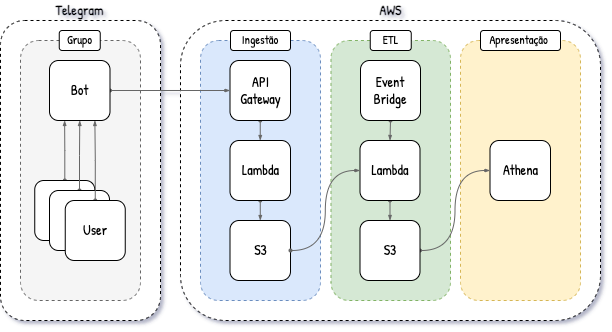

### Transacional

Na etapa transacional, utilizamos o Telegram como fonte de dados, pois, possui, pelo BotFather, um meio simples de criação de bots. Criaremos um bot em um grupo do Telegram do qual fará a ingestão de dados com o AWS API Gateway, que recebe as requisições HTTP contendo as mensagens e as encaminha para o AWS Lambda. Esse, por sua vez, armazena as mensagens em arquivos JSON no AWS S3, organizados por dia.

### Analítica

A etapa analítica, envolve o processo ETL (Extração, Transformação, Carregamento), diariamente o AWS EventBridge aciona um AWS Lambda, responsável por processar as mensagens do dia anterior. Durante essa etapa, os dados são denormalizados e salvos no formato Parquet no AWS S3, garantindo melhor performance e eficiência no armazenamento.

Por fim, para a apresentação dos dados, é criada uma tabela no AWS Athena, apontando para o bucket do AWS S3 onde os dados processados estão armazenados. A partir dela, consultas SQL podem ser realizadas para extrair insights valiosos.

## 3\. **Dados**

---



Depois da criação do bot e configura-lo para ser exclusivo de nosso grupo no Telegram, o adicionamos ao grupo e o tornamos administrador para que ele possa funcionar.

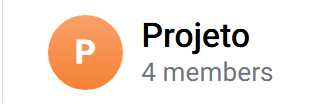

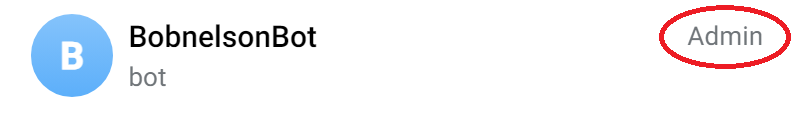

Em código Python, a biblioteca getpass é usada para capturar o token do bot sem expor seu token. A biblioteca Requests faz a conexão entre o código HTTP e a API do Telegram. Já a interpretação das respostas da API, recebidas em formato JSON, fica a cargo da biblioteca JSON, garantindo o correto processamento dos dados.

In [ ]:
from getpass import getpass

token = getpass()

··········


Definição da URL base para as requisições à API do Telegram

In [ ]:
import json
import requests

base_url = f'https://api.telegram.org/bot{token}'

O método **getMe** retorna informações sobre o bot.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "id": 7699794337,
    "is_bot": true,
    "first_name": "BobnelsonBot",
    "username": "BobnelsonBot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


O método **getUpdates** retorna as mensagens captadas pelo bot.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 945091471,
      "message": {
        "message_id": 5,
        "from": {
          "id": 7708608889,
          "is_bot": false,
          "first_name": "Lucas",
          "last_name": "Zulo",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002326954911,
          "title": "Projeto",
          "type": "supergroup"
        },
        "date": 1738943072,
        "text": "Mensagem de teste para o projeto"
      }
    },
    {
      "update_id": 945091472,
      "message": {
        "message_id": 6,
        "from": {
          "id": 7870009515,
          "is_bot": false,
          "first_name": "Marilene",
          "last_name": "Zulo"
        },
        "chat": {
          "id": -1002326954911,
          "title": "Projeto",
          "type": "supergroup"
        },
        "date": 1738943167,
        "text": "Esta mensagem serve para testar."
      }
    },
    {
      "update_id": 945091473,
      "me

### Processo de Tratamento dos Dados para Envio ao Telegram

Os dados recebidos chegam no formato JSON (semiestruturado) e precisam ser transformados em um formato estruturado. Para isso, realizamos a denormalização, organizando as informações de forma mais acessível.

A seguir, apresentamos um exemplo de estrutura, priorizando os campos obrigatórios e, entre os opcionais, considerando apenas mensagens de texto.

Exemplo:

In [16]:
%%writefile telegram.json
{
    "update_id": 123,
    "message": {
        "message_id": 1,
        "from": {
            "id": 321,
            "is_bot": false,
            "first_name": "Lucas"
        },
        "chat": {
            "id": -785435439,
            "title": "Projeto",
            "type": "group"
        },
        "date": 1640995200,
        "text": "Ola, mundo!"
    }
}

Overwriting telegram.json


Para maior flexibilidade de manipulação dos dados, salvamos as mensagens em seu formado bruto. Isso ajuda a preservar os dados.

**Eis a estrutura dos dados mostrada acima:**


* message_id: O número das mensagens
* user_id: ID do usuário
* user_is_bot: Booleano que verifica se o usuário é bot
* user_first_name: Primeiro nome do usuário
* chat_type: Tipo do chat
* date: Hora e data do envio da mensagem
* data_type: Tipo de dado (texto, audio, imagem)
* text: Mensagem enviada



### Wrangling

In [17]:
import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  data = data["message"]

In [18]:
print(json.dumps(data, indent=2))

{
  "message_id": 1,
  "from": {
    "id": 321,
    "is_bot": false,
    "first_name": "Lucas"
  },
  "chat": {
    "id": -785435439,
    "title": "Projeto",
    "type": "group"
  },
  "date": 1640995200,
  "text": "Ola, mundo!"
}


Com um laço de repetição, vamos varrer todas as chaves do arquivo e selecionar apenas as de interesse. Caso o campo *text* não esteja presente, ele será atribuído como None.
Adicionamos *context_date* e *context_timestamp* para registrar o momento exato do processamento.

In [19]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [20]:
for k, v in parsed_data.items():
  print(f"{k}: {v}")

message_id: [1]
user_id: [321]
user_is_bot: [False]
user_first_name: ['Lucas']
chat_id: [-785435439]
chat_type: ['group']
date: [1640995200]
text: ['Ola, mundo!']
context_date: ['2025-02-10']
context_timestamp: ['2025-02-10 04:00:24']


Neste projeto vamos trabalhar com SQL, a conversão será feita no formato **parquet** para particionamento e economizar no gasto de dados nas consultas no AWS Athena.

In [22]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

table

pyarrow.Table
message_id: int64
user_id: int64
user_is_bot: bool
user_first_name: string
chat_id: int64
chat_type: string
date: int64
text: string
context_date: string
context_timestamp: string
----
message_id: [[1]]
user_id: [[321]]
user_is_bot: [[false]]
user_first_name: [["Lucas"]]
chat_id: [[-785435439]]
chat_type: [["group"]]
date: [[1640995200]]
text: [["Ola, mundo!"]]
context_date: [["2025-02-10"]]
context_timestamp: [["2025-02-10 04:00:24"]]

## 4\. Ingestão


---



4.1. Criação de um bucket no **AWS S3** para o armazenamento de dados crus, não se esqueça de adicionar o sufixo **-raw**.

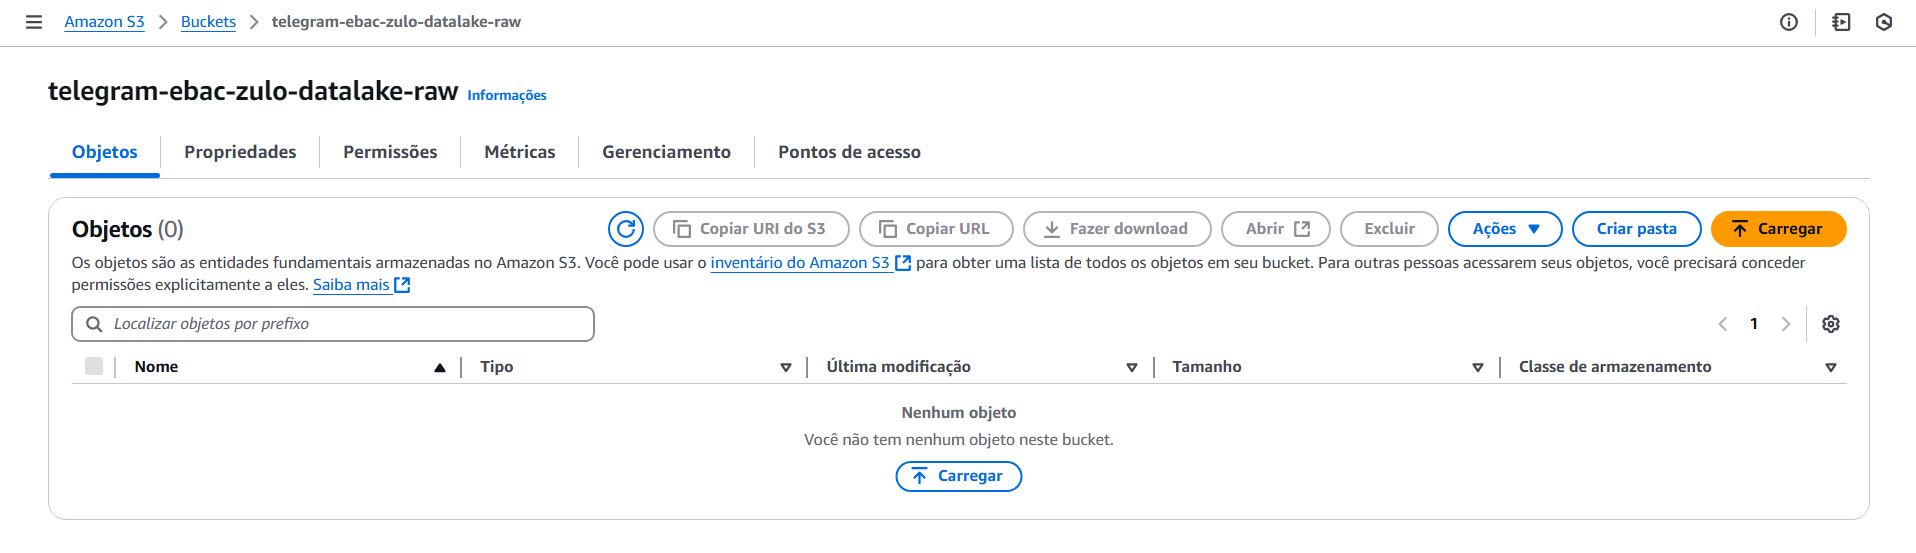

4.2. Criação de uma função no **AWS Lambda** para recebimento das mensagens e armazenamento no formato JSON no bucket de dados crus.
Configuração das variáveis de ambiente e adicionamento das permissões de interação com **AWS S3** no **AWS IAM**.

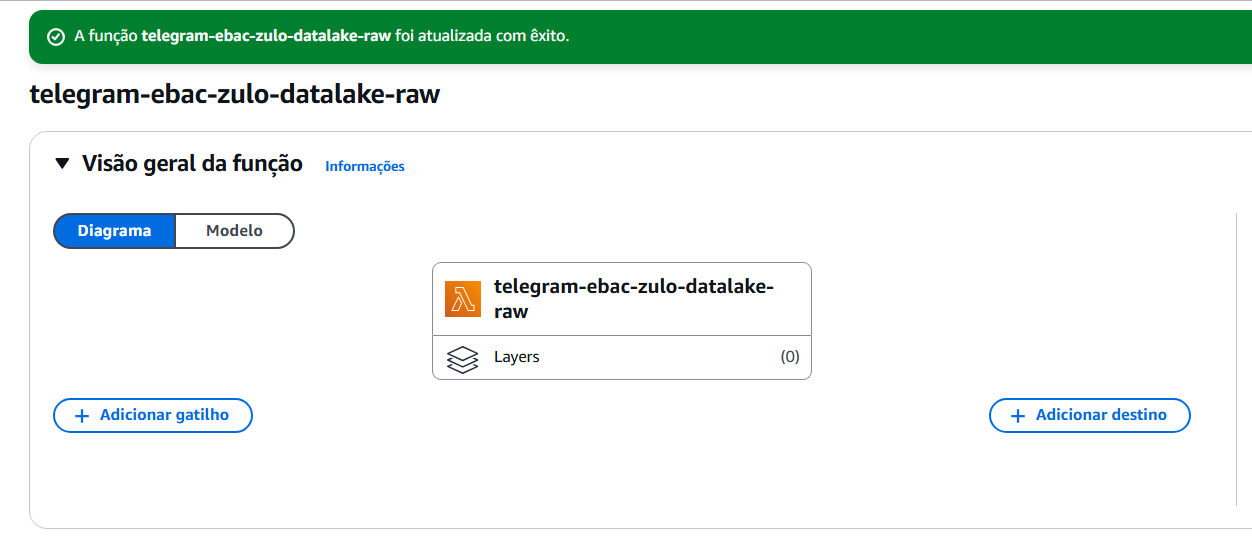

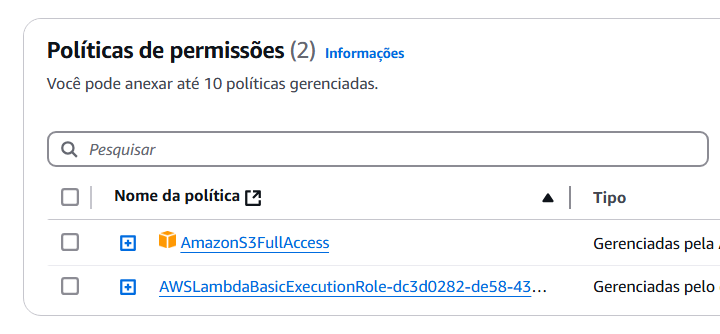

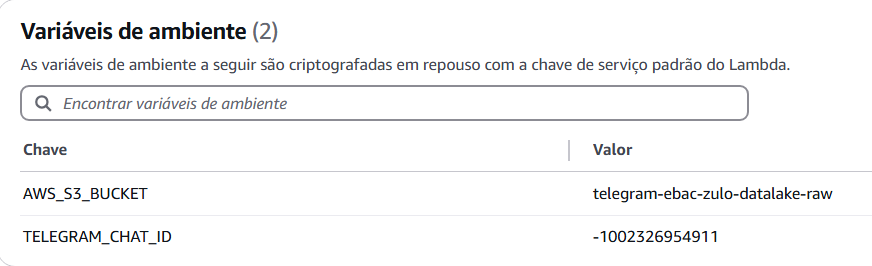

4.3. Função Lambda

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

4.4. Criação da API no **AWS API Gateway** conectada à função do **AWS Lambda**.

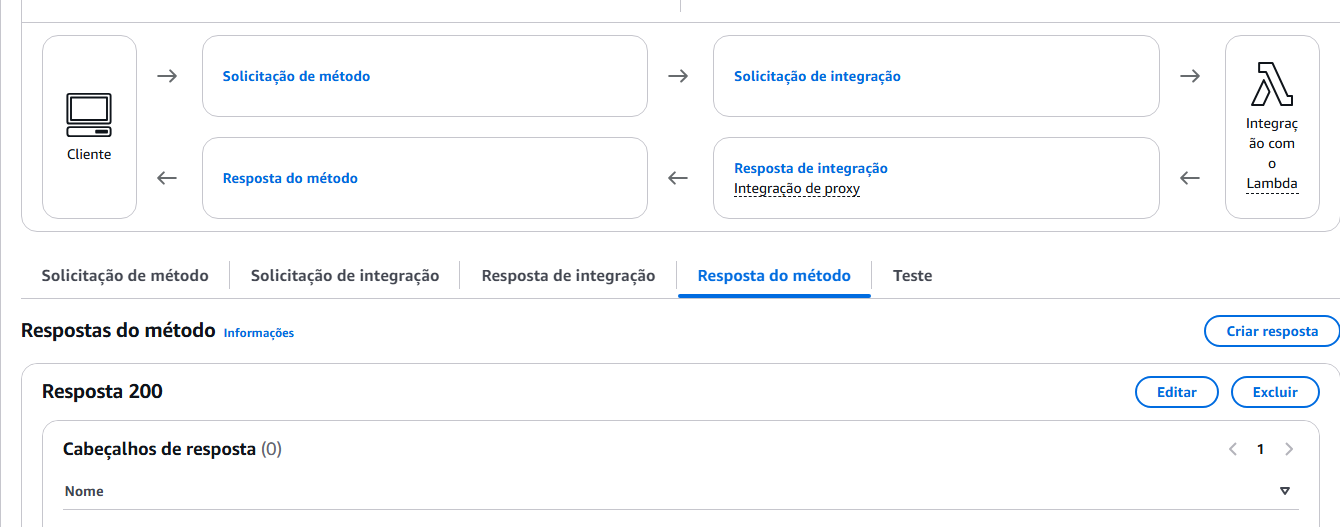

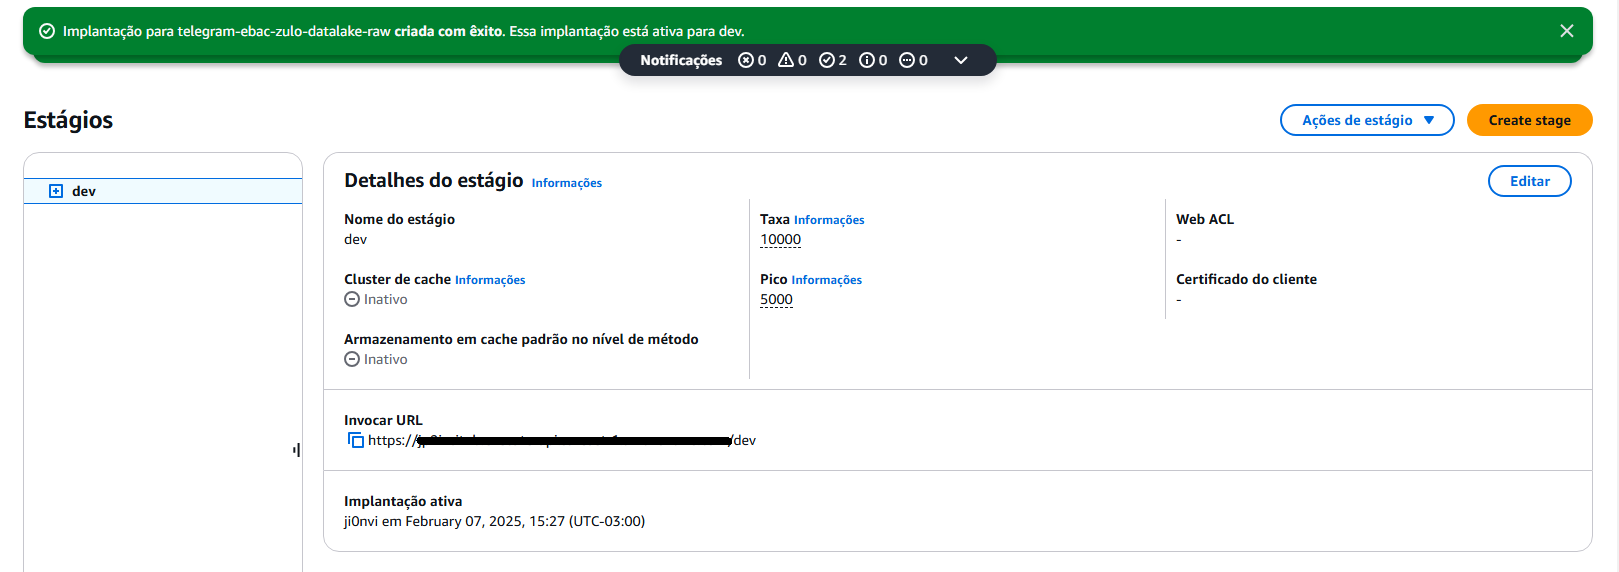

4.5. Copiando a url gerada na variável *aws_api_gateway_url*.

In [ ]:
aws_api_gateway_url = getpass()

··········


4.6. Configuração **webhook** do bot através do método **setWebhook** da API de bots do Telegram.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


> O método **getWebhookInfo** retorna as informações sobre o webhook configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://jp2ivcitnb.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "54.207.154.147"
  }
}


> As mensagens novas tem conexção com o o bucket do AWS S3.

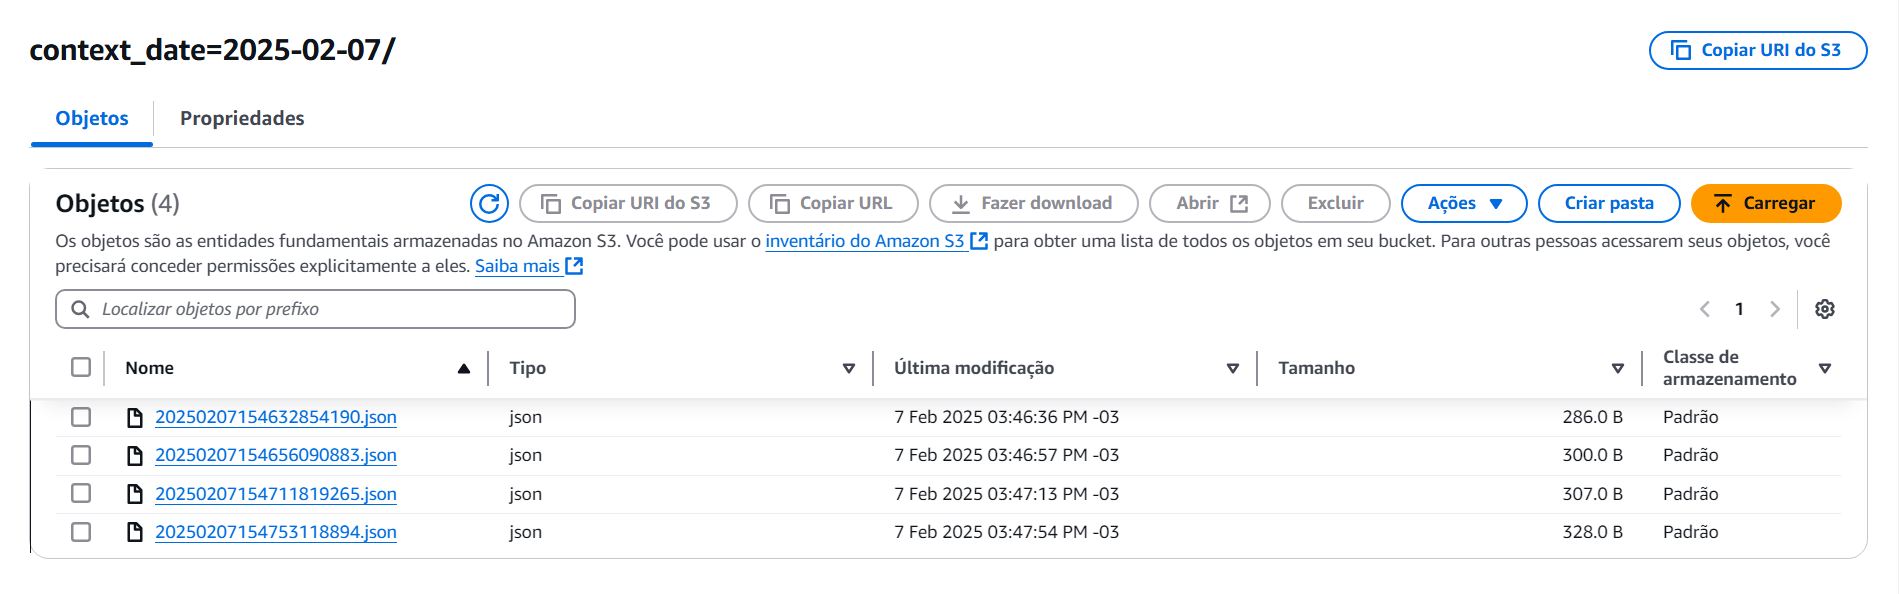

## 5\. ETL (Extração, Transformação e Carga)

---



Nesta etapa, os dados brutos (raw) são primeiramente armazenados em um bucket S3 e passam por um processo de data wrangling, que inclui limpeza e remoção de duplicatas. Após esse tratamento, eles são compactados em um único arquivo estruturado, utilizando um formato comprimido orientado a colunas, ideal para análise eficiente.

A execução do processo é automatizada por uma função AWS Lambda, acionada diariamente por uma regra do AWS EventBridge. Essa função realiza todas as etapas do ETL, garantindo que os dados processados sejam armazenados em um bucket S3, na camada enriquecida.

5.1. Criação de bucket enriched no **AWS S3** para o armazenamento de dados enriquecidos.

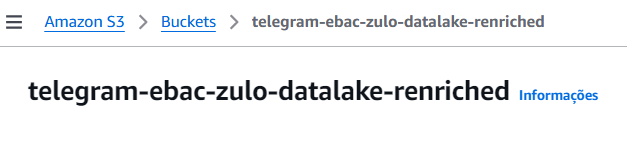

5.2. Criação de uma função no **AWS Lambda** para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no bucket de dados crus. O resultado é salvo em um único arquivo PARQUET, também particionado por dia.. Também configuramos as variáveis de ambiente, de adicionamos as permissão de interação com **AWS S3** no **AWS IAM**, configuramos o *timeout* e, por fim, adicionamos a *layer* com o código do pacote Python PyArrow.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

> O código da função de *data wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

> Função Enriched criada.

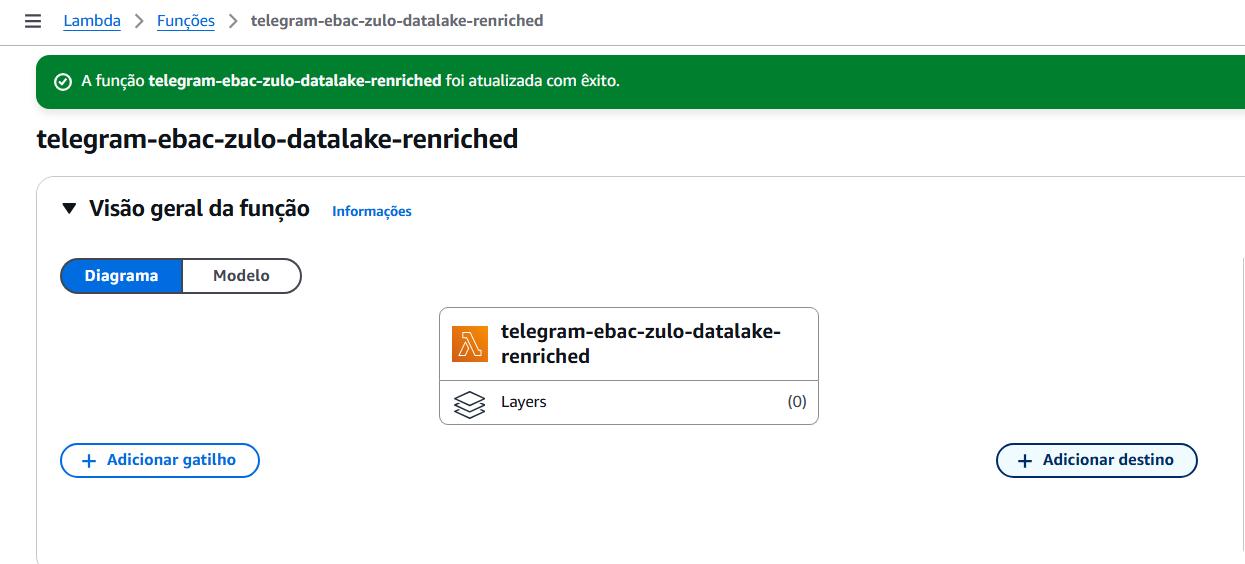

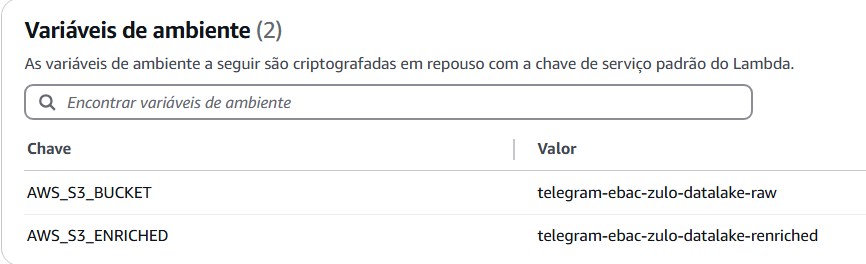

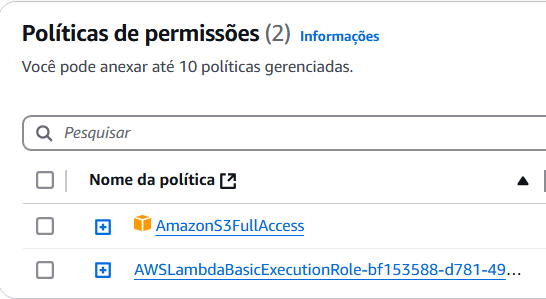

> Aumentando o timeout padrão de funcões do AWS Lambda de 3 segundos para 5 minutos, para lidar com o IO (input/output) de arquivos do AWS S3.

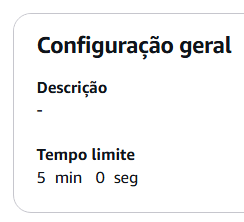

> **Camadas**

* Criação de um bucket no AWS S3

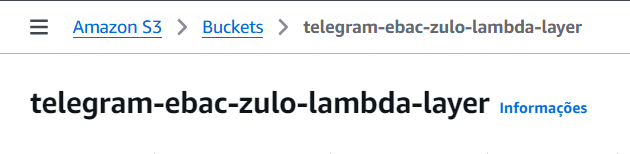

* Criação da layer e conectando à função

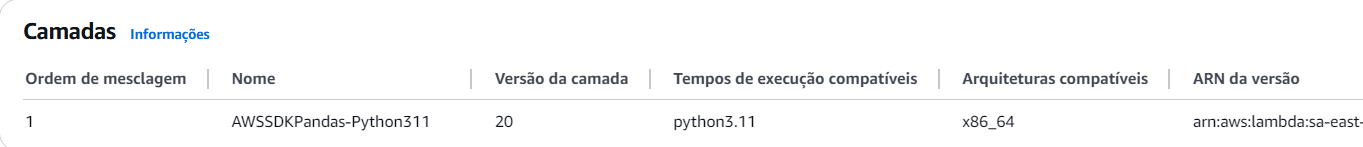

5.3. Criação de uma regra no **AWS Event Bridge** para executar a função do **AWS Lambda** todo dia a meia noite no horário de Brasília, levando em conta o fuso horário (GMT-3).

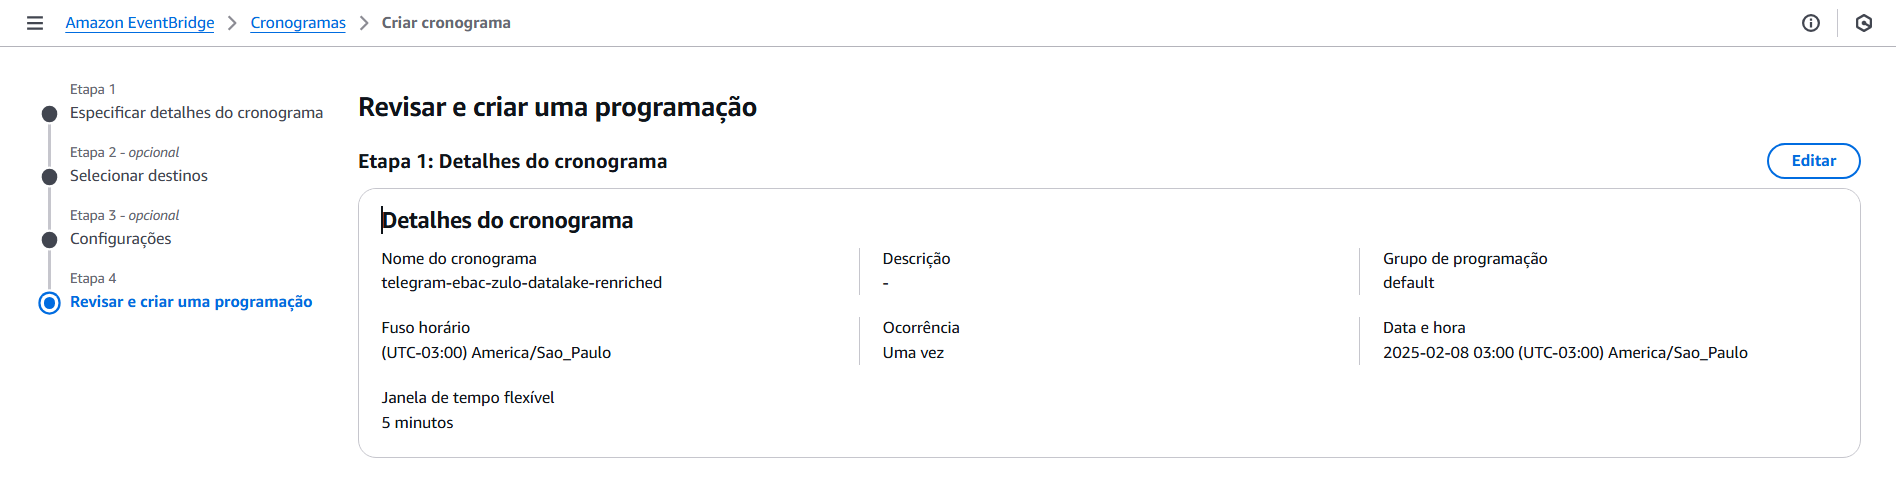

## 6\. Apresentação

---



6.1. No **AWS Athena**, que se conecta aos dados armazenados no bucket enriquecido do **AWS S3**, criamos uma tabela para consulta dos dados.

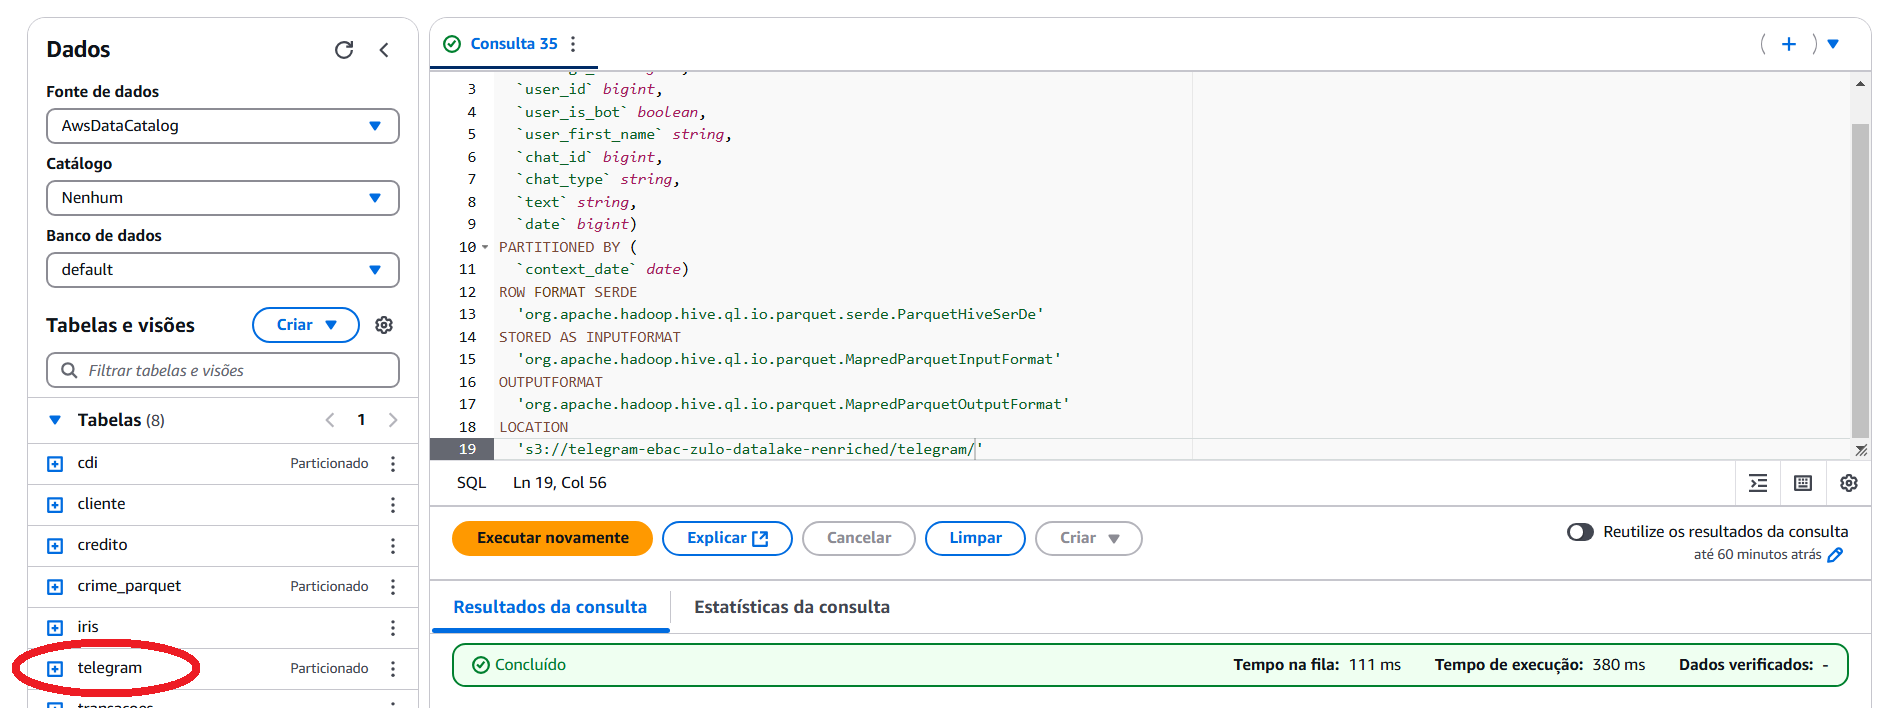

6.2. O comando *MSCK REPAIR TABLE* carrega as partições.

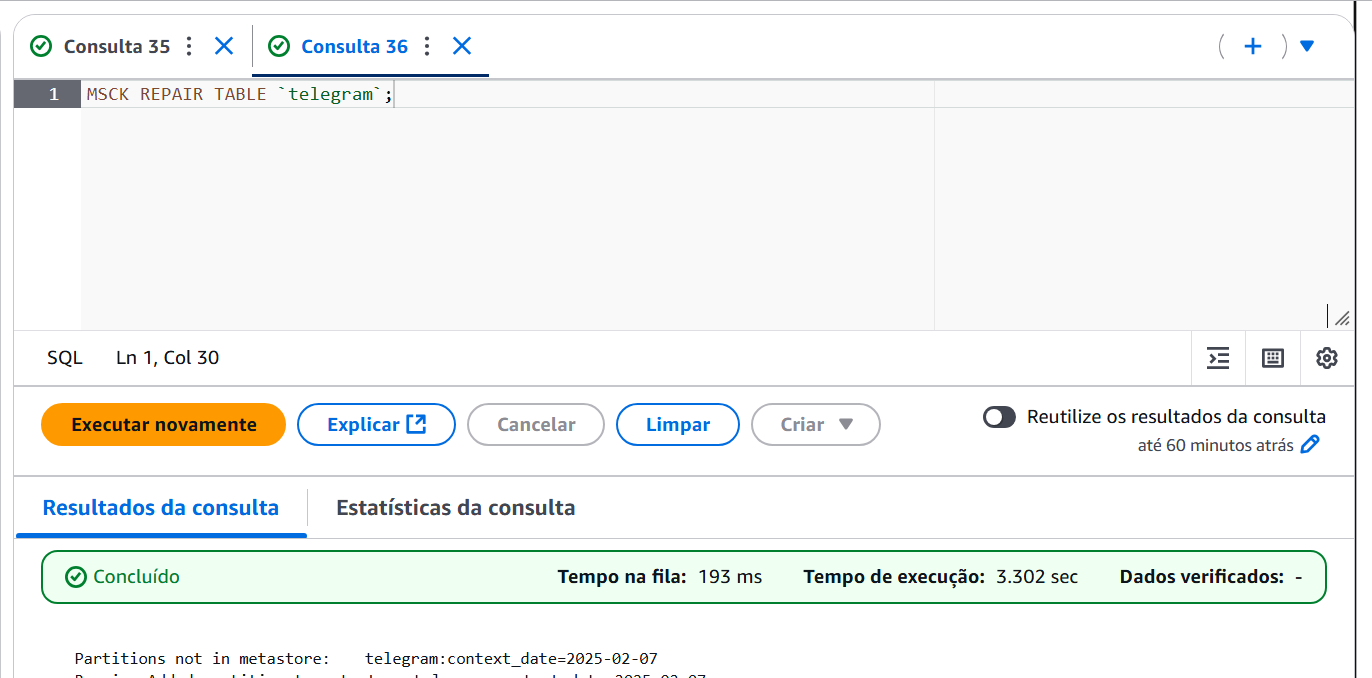

6.3. Execução do comando SELECT*FROM telegram LIMIT 10;

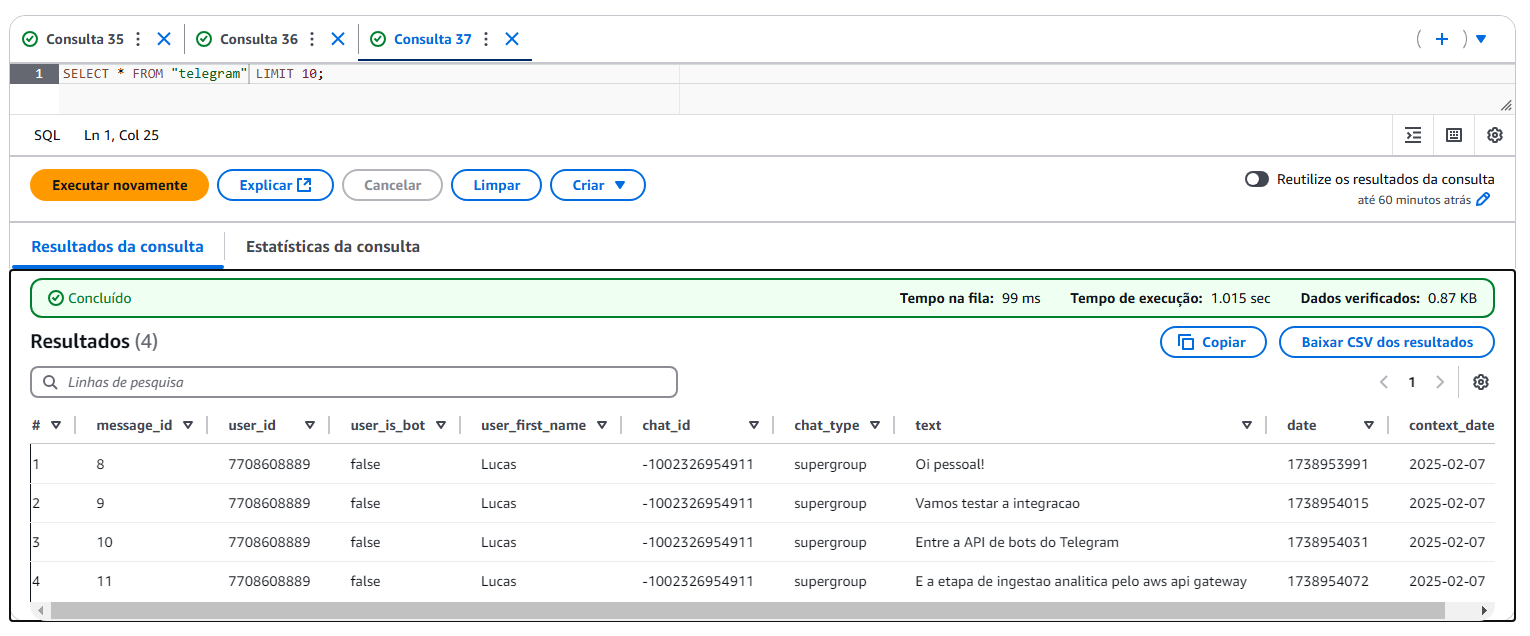

### Análise

1. Quantidade de mensagens por dia.

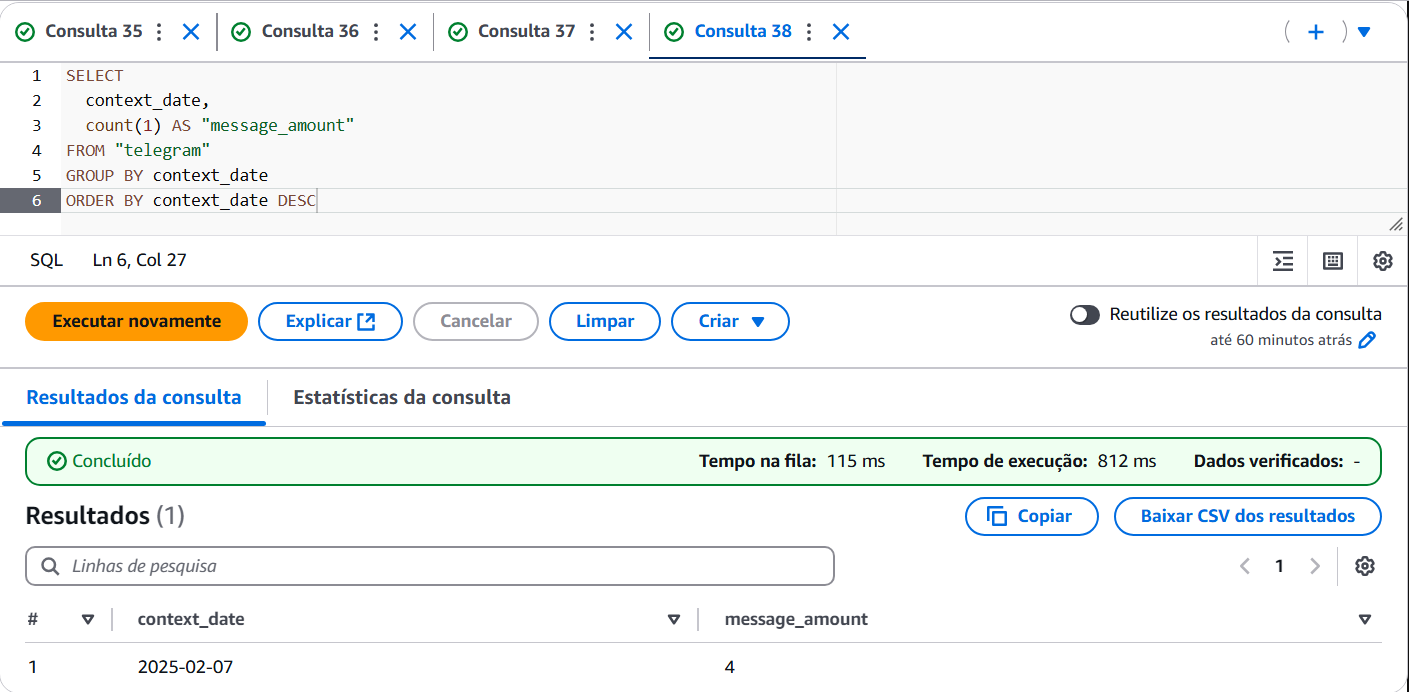

2. Quantidade de mensagens por usuário por dia.

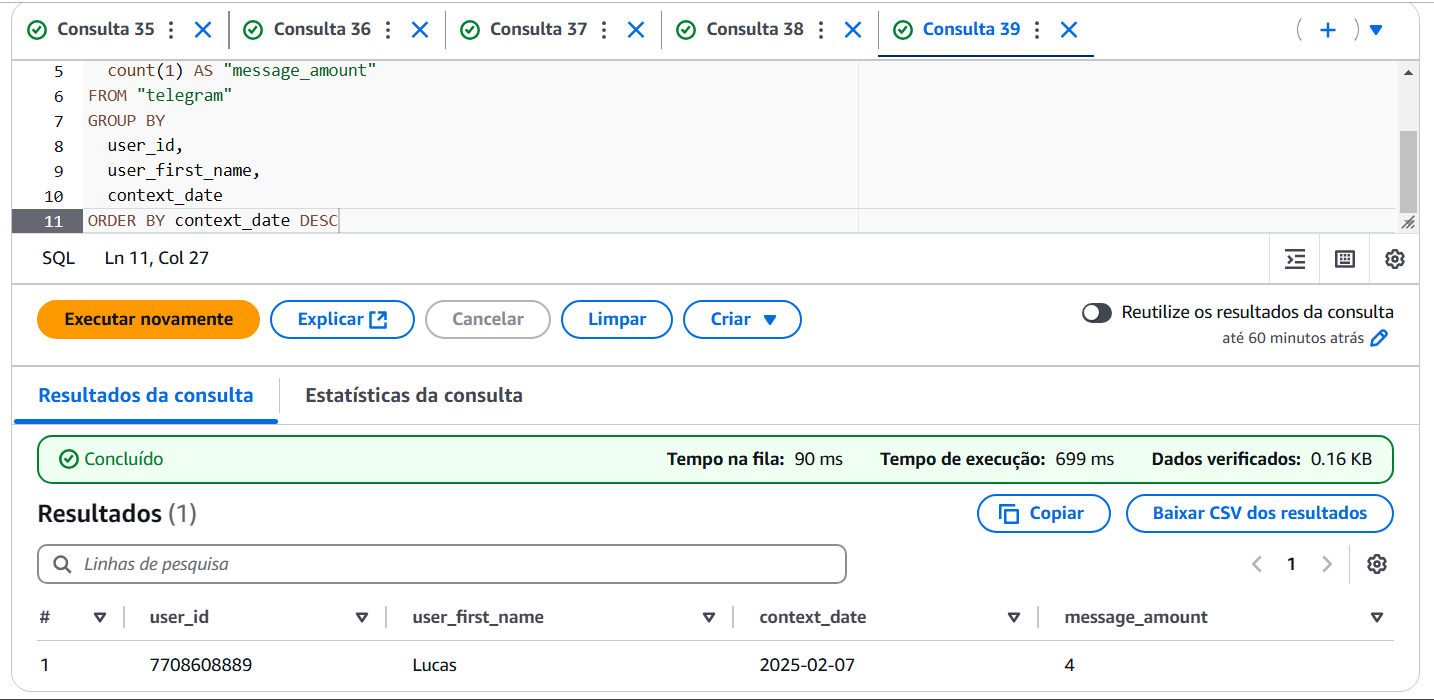

3. Média do tamanho das mensagens por usuário por dia.

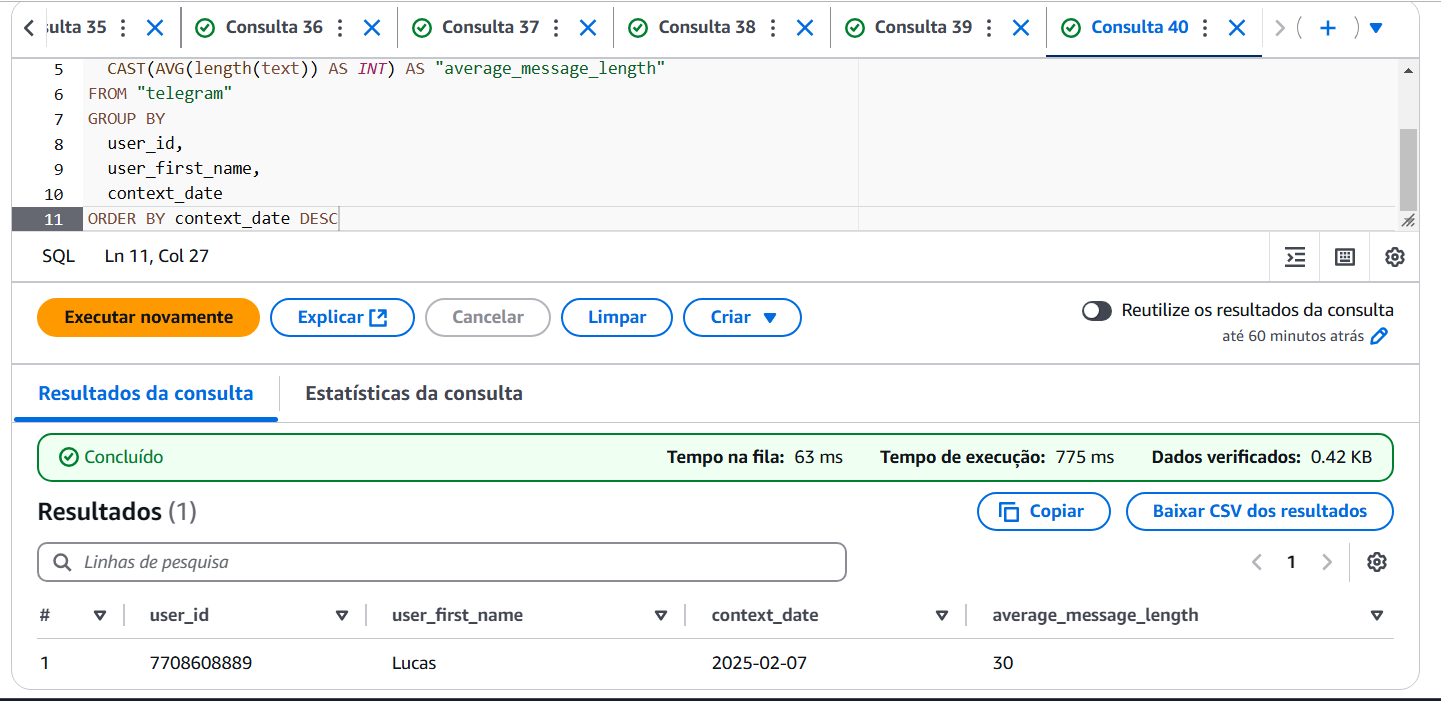

4. Quantidade de mensagens por hora por dia da semana por número da semana.

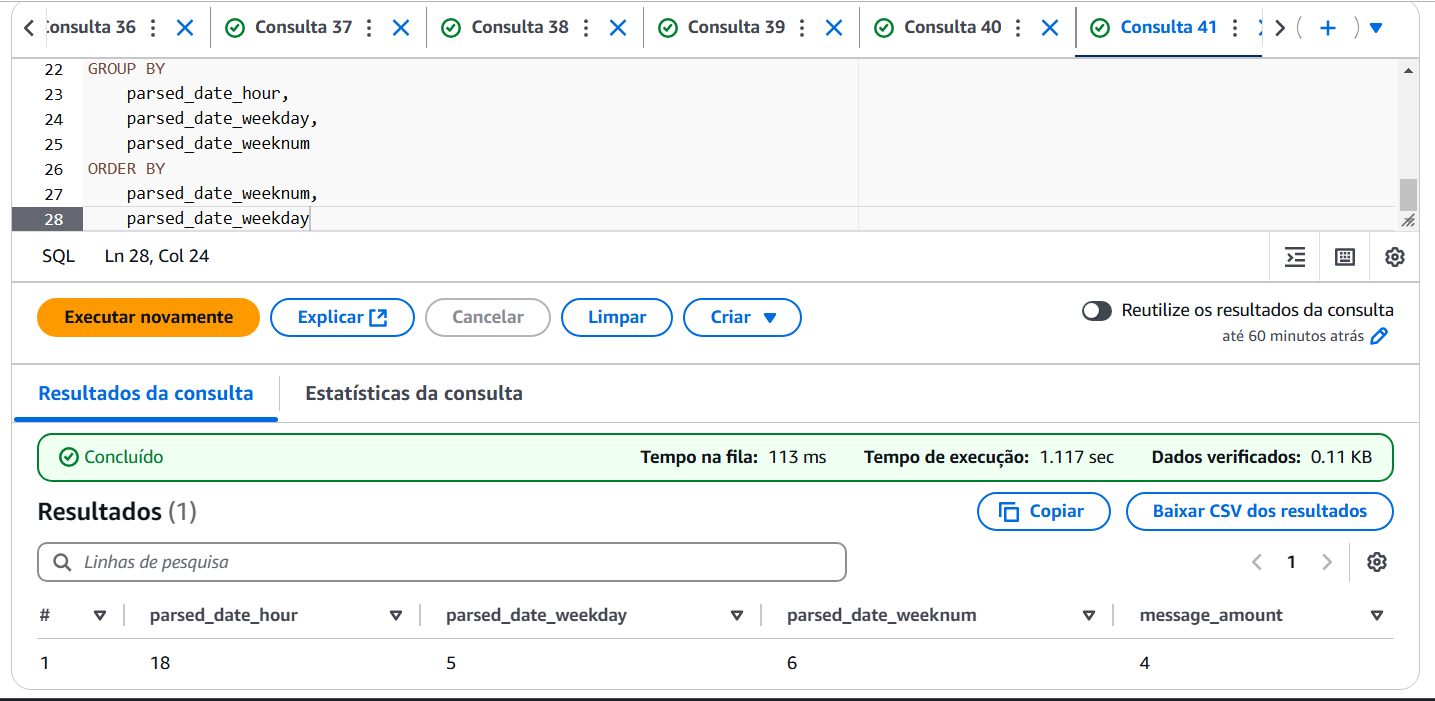

## 7\. Storytelling

---



Siga as dicas da aula 4 para expor o seu projeto.

> A análise visa extrair insights sobre o comportamento dos usuários, como padrões de atividade, principais tópicos de conversa e características das mensagens. As informações obtidas podem ser úteis para entender a dinâmica do grupo e otimizar estratégias de comunicação.

* O número de mensagens enviadas foi 4.
* Todas as mensagens foram enviadas no dia 07/02/2025 e, futuras cunsultas serão feitas para dar mais robustez ao projeto.
* O comprimento médio das mensagens varia de 11 à 52 caracteres.
* Lucas foi quem enviou a mensagem mais curta (11 caracteres). Lucas também enviou a mensagem mais longa (52 caracteres).
* O comprimento da primeira mensagem é mais curto do que as três mensagens seguintes. Isso pode indicar diferentes estilos de comunicação ou propósitos de mensagens diferentes.
* Todas as mensagens foram enviadas na sexta-feita.
* O pico de mensagens ocorreu às 18 horas, com 4 mensagens.
* Esses padrões refletem os hábitos pessoais, dada a preferência de comunicação do usuário à noite, bem como a prevalência de mensagens em dias úteis.
* A palavra mais recorrente nas mensagens é "API", entre "integração", "analítica"e "bots".
* Isso pode indicar que o grupo de Telegram é usado principalmente para fins profissionais ou relacionados à tecnoligia.
* Todas as mensagens foram enviada por usuários, não por bots. Isso pode indicar que o grupo de Telegram é usado principalmente para comunicação humana e não para interações automatizadas.

## 8\. Conclusões

---



* Pico de atividade às 18 horas: Sugere evento específico ou hábitos noturnos dos usuários.
* Mensagens frequentes que remetem ao ambiente de trabalho ou estudos: Indicam foco relacionado à tecnoligia.
* Variação no comprimento das mensagens: Reflete diferentes estilos de comunicação entre os usuários (Mensagens curtas para saudação, e mensagens mais longas para instruções).
* Predomínio de mensagens enviadas por uma pessoa: Baixa participação de bots. Concentração da atividade na sexta-feira: Não houve mensagens nos demais dias da semana.